# Visualisations For Model Training and Predictions

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from PreprocessData import * # import from custom transformers 
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Look at dataset

In [8]:
site_list = pd.read_csv('../DATASETS/Sites_Subset_20231010/ausplots_site_info/sites_subset.csv').copy()

Now, while the first half of the dataset being successfully preprocessed:

In [4]:

window_length = 5
# savgol_filter parameters 
window_length_smooth = 15
polyorder = 4 


site_location_names =  np.unique(site_list.site_location_name)

scores = pd.DataFrame({'site_location_name': [site_location_names[0]],
                      'lag':[pd.NA],
                      'window': [pd.NA],
                      'R2': [pd.NA]})

for site_location_name in site_location_names:

    site = pd.read_csv(f'../DATASETS/DEA_FC_PROCESSED/SPATIAL_AND_UE_FILTER/{site_location_name}.csv', parse_dates=['time'])

    time_fc_pipeline = Pipeline([
        ('preprocess_fc_time_series', preprocess_fc_time_series(window_length = window_length_smooth, polyorder = polyorder)),
        ('time_attributes_adder', time_attributes_adder()),
     ])
    site_resampled = time_fc_pipeline.fit_transform(site)

    precip = pd.read_csv(f'../DATASETS/Climate_Gridded/Precip/{site_location_name}_1987_2022.csv', parse_dates=['time'])

    lag = [i for i in range(1,50)]
    window = [i for i in range(1,50)]

    models_fitted_count = len(lag)*len(window)
    m = 0


    for w in window:

        for l in lag:

            time_climate_pipeline = Pipeline([
                    ('preprocess_climate_time_series', preprocess_climate_time_series()),
                    ('climate_time_series_downsample', climate_time_series_downsample(start_time = site_resampled.index[0], resample_method = 'sum')),
                    ('time_attributes_adder', time_attributes_adder()),
                    ('climate_time_series_attributes_adder', climate_time_series_attributes_adder(window = w, lag = l))
            ])

            precip_new = time_climate_pipeline.fit_transform(precip)
            temp = site_resampled.copy().merge(precip_new, how = 'left', left_index = True, right_index = True, validate = "one_to_one",
                                                  suffixes = ('', '_DUPLICATE'))
            temp = temp.drop(columns =  temp.filter(regex = '_DUPLICATE$').columns)
            temp = temp.copy()

            # Now fit a model to see the R2 score 
            FEATURES = 'precip_rolling'
            site_merged_model = temp.copy().dropna(subset = FEATURES)
            X = site_merged_model['precip_rolling'].copy().dropna().to_numpy().reshape(-1,1)
            y = site_merged_model['pv_filter'].to_numpy()
            score = LinearRegression().fit(X,y).score(X,y)

            row = pd.Series({'site_location_name': site_location_name, 'lag': l, 'window': w, 'R2': score})
            scores = pd.concat([scores, row.to_frame().T], ignore_index=True)
            m += 1 

            if m % 100 == 0:
                print(m)


scores = scores.dropna()

            Unnamed: 0         x          y         bs         pv        npv  \
time                                                                           
1987-09-12         1.5  608165.0  6531775.0  31.260331  25.855372  41.623967   
1987-09-28         3.5  608165.0  6531775.0  33.190083  21.855372  43.690083   
1987-10-14         5.5  608165.0  6531775.0  44.309917  15.024793  39.297521   
1987-10-30         7.5  608165.0  6531775.0  21.541322  21.685950  55.909091   
1987-11-15         9.0  608165.0  6531775.0  46.553719  13.933884  38.247934   
...                ...       ...        ...        ...        ...        ...   
2023-02-03      1544.0  608165.0  6531775.0  35.553719  13.553719  49.487603   
2023-02-19      1545.5  608165.0  6531775.0  38.090909  16.074380  44.289256   
2023-03-07      1547.5  608165.0  6531775.0  39.657025  15.132231  43.640496   
2023-03-23      1549.0  608165.0  6531775.0  39.776860  15.239669  43.479339   
2023-04-08      1550.0  608165.0  653177

In [5]:
scores

,site_location_name,lag,window,R2
1,NSABHC0023,1,1,0.044317
2,NSABHC0023,2,1,0.078003
3,NSABHC0023,3,1,0.109684
4,NSABHC0023,4,1,0.124313
5,NSABHC0023,5,1,0.117354
...,...,...,...,...
28808,WAAPIL0003,45,49,0.052086
28809,WAAPIL0003,46,49,0.043692
28810,WAAPIL0003,47,49,0.038809
28811,WAAPIL0003,48,49,0.037284


In [5]:
site_list = pd.read_csv('../DATASETS/Sites_Subset_20231010/ausplots_site_info/sites_subset.csv').copy()
site_scores = pd.read_csv('site_scores.csv', usecols =  ['site_location_name', 'lag', 'window', 'R2'])

In [6]:
site_scores

,site_location_name,lag,window,R2
0,NSABHC0023,1,1,0.044317
1,NSABHC0023,2,1,0.078003
2,NSABHC0023,3,1,0.109684
3,NSABHC0023,4,1,0.124313
4,NSABHC0023,5,1,0.117354
...,...,...,...,...
28807,WAAPIL0003,45,49,0.052086
28808,WAAPIL0003,46,49,0.043692
28809,WAAPIL0003,47,49,0.038809
28810,WAAPIL0003,48,49,0.037284


In [7]:
site_scores = site_scores.merge(site_list, left_on = 'site_location_name', right_on = 'site_location_name')

In [8]:
site_scores

,site_location_name,lag,window,R2,Unnamed: 0,site_unique,established_date,description,bioregion_name,landform_pattern,...,pit_marker_location_method,soil_observation_type,a_s_c,plot_is_100m_by_100m,plot_is_aligned_to_grid,plot_is_permanently_marked,latitude,longitude,point,state
0,NSABHC0023,1,1,0.044317,226,NSABHC0023-57099,2014-04-21T00:00:00,Langawirra Station. 11.3km north of homestead....,BHC,PLA,...,NaN,P,NaN,True,True,True,-31.343950,142.136553,SW,NSW
1,NSABHC0023,2,1,0.078003,226,NSABHC0023-57099,2014-04-21T00:00:00,Langawirra Station. 11.3km north of homestead....,BHC,PLA,...,NaN,P,NaN,True,True,True,-31.343950,142.136553,SW,NSW
2,NSABHC0023,3,1,0.109684,226,NSABHC0023-57099,2014-04-21T00:00:00,Langawirra Station. 11.3km north of homestead....,BHC,PLA,...,NaN,P,NaN,True,True,True,-31.343950,142.136553,SW,NSW
3,NSABHC0023,4,1,0.124313,226,NSABHC0023-57099,2014-04-21T00:00:00,Langawirra Station. 11.3km north of homestead....,BHC,PLA,...,NaN,P,NaN,True,True,True,-31.343950,142.136553,SW,NSW
4,NSABHC0023,5,1,0.117354,226,NSABHC0023-57099,2014-04-21T00:00:00,Langawirra Station. 11.3km north of homestead....,BHC,PLA,...,NaN,P,NaN,True,True,True,-31.343950,142.136553,SW,NSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40812,WAAPIL0003,45,49,0.052086,189,WAAPIL0003-57601,2015-08-30T11:01:10,Millstream Chichester National Park. 200m east...,PIL,RIS,...,DGPS,P,NaN,True,True,True,-21.541103,117.057006,SW,WA
40813,WAAPIL0003,46,49,0.043692,189,WAAPIL0003-57601,2015-08-30T11:01:10,Millstream Chichester National Park. 200m east...,PIL,RIS,...,DGPS,P,NaN,True,True,True,-21.541103,117.057006,SW,WA
40814,WAAPIL0003,47,49,0.038809,189,WAAPIL0003-57601,2015-08-30T11:01:10,Millstream Chichester National Park. 200m east...,PIL,RIS,...,DGPS,P,NaN,True,True,True,-21.541103,117.057006,SW,WA
40815,WAAPIL0003,48,49,0.037284,189,WAAPIL0003-57601,2015-08-30T11:01:10,Millstream Chichester National Park. 200m east...,PIL,RIS,...,DGPS,P,NaN,True,True,True,-21.541103,117.057006,SW,WA


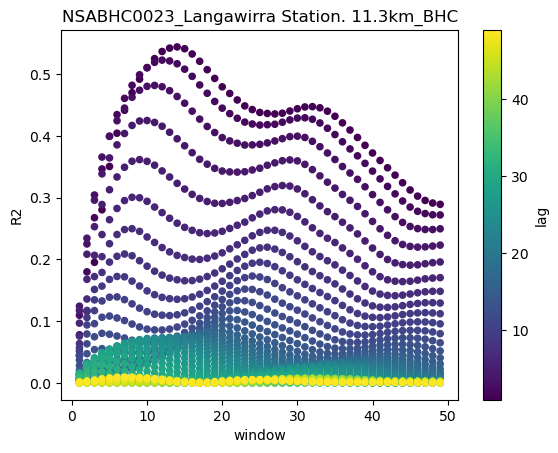

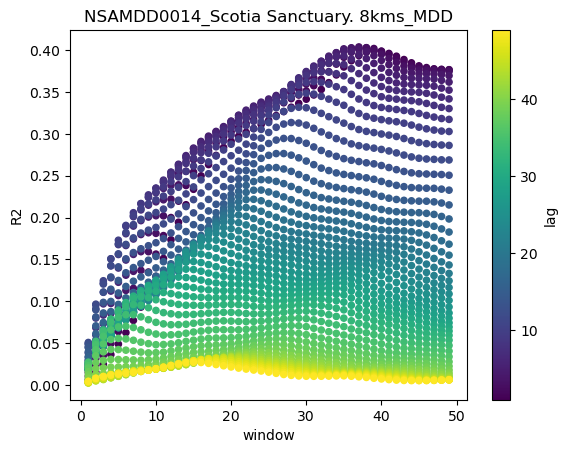

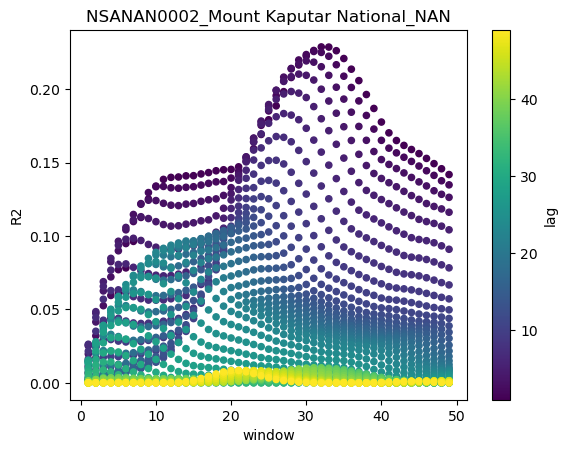

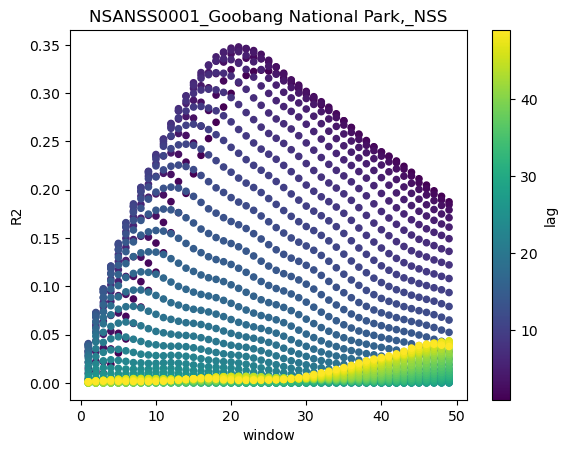

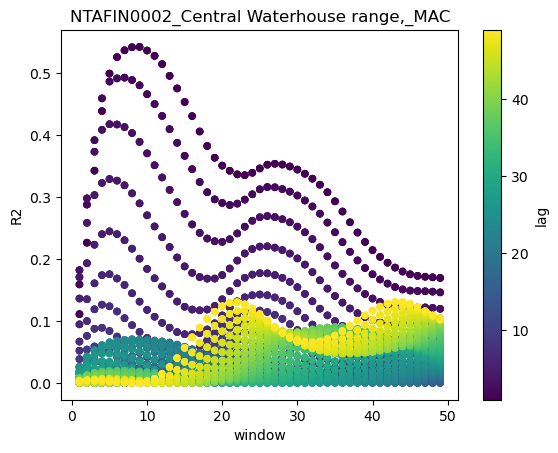

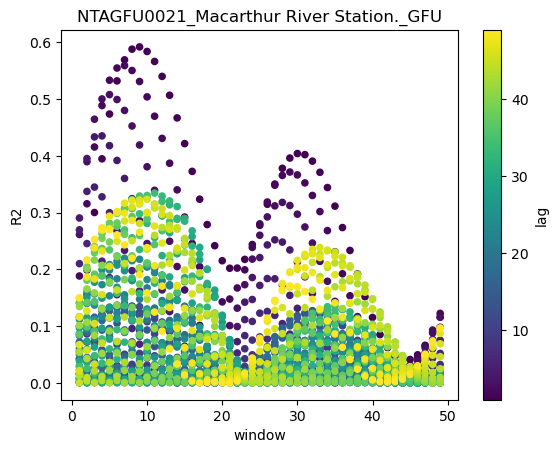

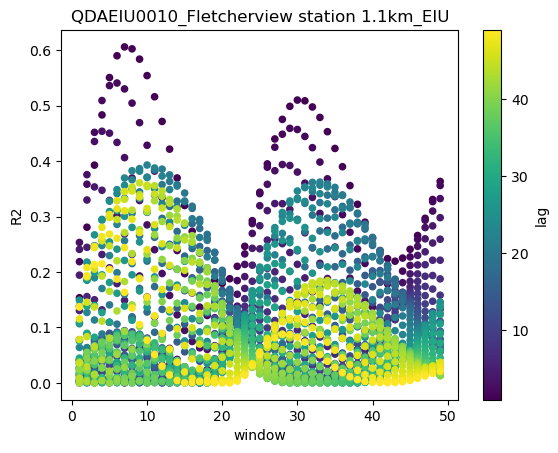

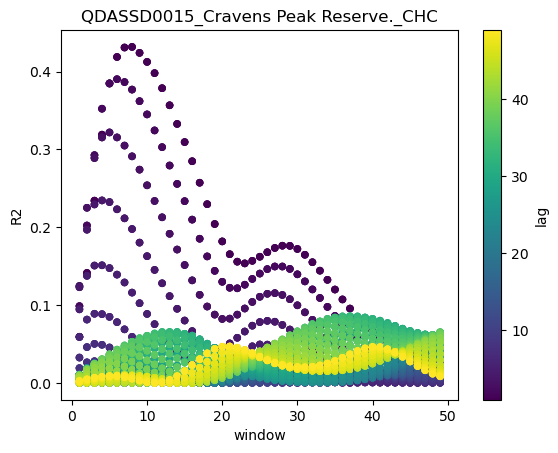

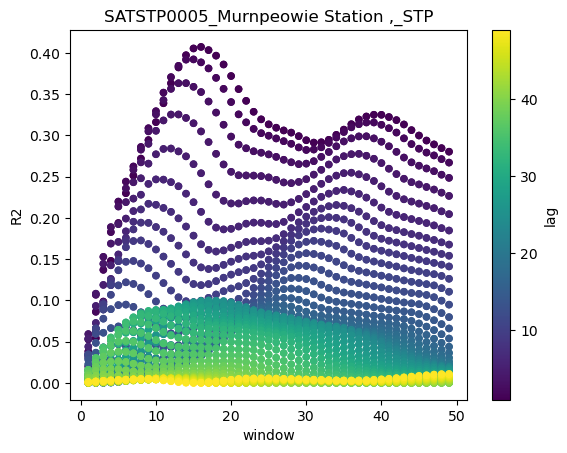

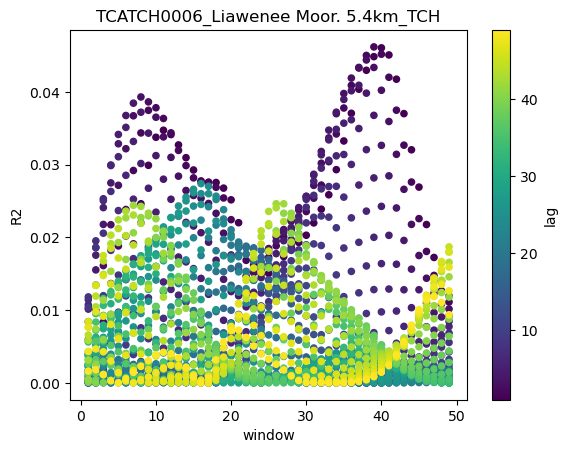

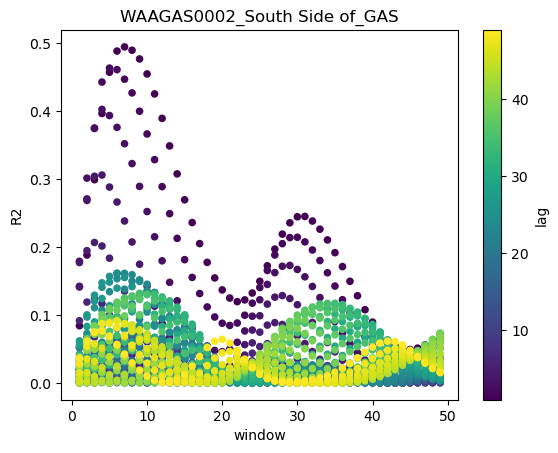

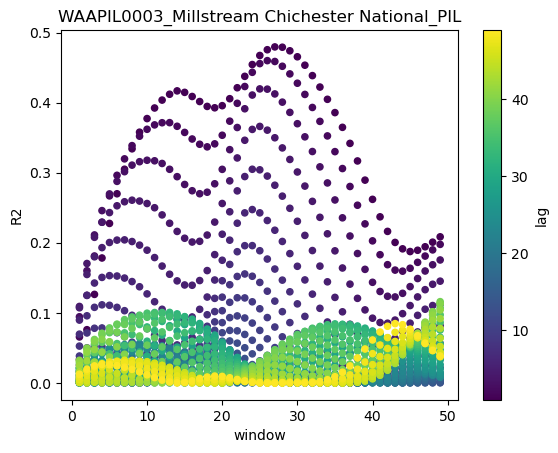

In [9]:
site_scores_grp = site_scores.groupby('site_location_name')

for key in site_scores_grp.groups.keys():
    site = site_scores_grp.get_group(key)
    first_index = site.index[0] # information will be constant per group so take the first one for simplicity
    site_bioregion_name = site.bioregion_name[first_index] 
    site_description = site.description[first_index].split(' ')
    site_description_str = ' '.join(site_description[:3])
    site.plot.scatter(x = 'window', y = 'R2', c = 'lag', colormap = 'viridis', title = f'{key}_{site_description_str}_{site_bioregion_name}')
    
    

In [10]:
#site_location_name = 'NSAMDD00014' # no fire, seasonal
#site_location_name = 'TCATCH0006' # no fire 
#site_location_name = 'NSANAN0002' # fire, seasonal, big drop

site_location_name = 'NSANSS0001'
time_lag = 5
window_length = 5
month_baseline = 3

# savgol_filter parameters 
window_length_smooth = 15
polyorder = 4 

def get_site_data(site_location_name, time_lag = 5, window_length = 5, month_baseline = 3, window_length_smooth = 15, polyorder = 4):

    historical_fire_ds = gpd.read_file('../DATASETS/AusPlots_Historical_BurnDates.shp', parse_dates = ['igntn_d'])
    historical_fire_pipeline = Pipeline([
        ('historical_burn_date_preprocess', historical_burn_date_preprocess(site_location_name))
    ])
    historical_fire_ds = historical_fire_pipeline.fit_transform(historical_fire_ds)
    print(historical_fire_ds)
    
    site = pd.read_csv(f'../DATASETS/DEA_FC_PROCESSED/SPATIAL_AND_UE_FILTER/{site_location_name}.csv', parse_dates=['time'])
    
    # Check if the fire dataset is empty; no recorded fires for the particular site
    if not historical_fire_ds.empty:
    
        time_fc_pipeline = Pipeline([
            ('preprocess_fc_time_series', preprocess_fc_time_series(window_length = window_length_smooth, polyorder = polyorder)),
            ('time_attributes_adder', time_attributes_adder()),
            ('historical_burn_date_attribute_adder', historical_burn_date_attribute_adder(historical_fire_ds, time_lag = time_lag))
         ])
        site_resampled = time_fc_pipeline.fit_transform(site)

        ## Filter out the rows that were recently affected by fire 
        fire_filter = site_resampled[(site_resampled['days_since_fire'] >= 0) & (site_resampled['days_since_fire'] <= 32)]
    else:
        # Don't perform filtering or add the fire date attributes
        time_fc_pipeline = Pipeline([
            ('preprocess_fc_time_series', preprocess_fc_time_series(window_length = window_length_smooth, polyorder = polyorder)),
            ('time_attributes_adder', time_attributes_adder()),
         ])
        site_resampled = time_fc_pipeline.fit_transform(site)
    
    climate_variables = pd.DataFrame({'climate_var': ['Precip'],
                                     'resample_type': ['sum']})
    datasets = dict()

    for index, row in climate_variables.iterrows():

        climate = pd.read_csv(f'../DATASETS/Climate_Gridded/{row["climate_var"]}/{site_location_name}_1987_2022.csv', parse_dates=['time'])

        datasets[row['climate_var']] = climate

        time_climate_pipeline = Pipeline([
            ('preprocess_climate_time_series', preprocess_climate_time_series()),
            ('climate_time_series_downsample', climate_time_series_downsample(start_time = site_resampled.index[0], resample_method = row['resample_type'])),
        ])
        climate_new = time_climate_pipeline.fit_transform(climate)
        site_resampled = site_resampled.merge(climate_new, how = 'left', left_index = True, right_index = True, validate = "one_to_one",
                                           suffixes = ('', '_DUPLICATE'))
        site_resampled = site_resampled.drop(columns =  site_resampled.filter(regex = '_DUPLICATE$').columns)

    return site_resampled.copy()

In [11]:
test = get_site_data("NTAGFU0021")

No Fire Dates for NTAGFU0021 avaliable
Empty DataFrame
Columns: [igntn_d, Name]
Index: []
            Unnamed: 0         x          y         bs         pv        npv  \
time                                                                           
1987-09-07    1.000000  600575.0  8151745.0  25.495868  21.462810  51.677686   
1987-09-23    2.000000  600575.0  8151745.0  30.801653  20.305785  47.694215   
1987-10-09    3.000000  600575.0  8151745.0  32.099174  20.504132  46.190083   
1987-10-25    4.000000  600575.0  8151745.0  31.735537  20.454545  46.272727   
1987-11-10    5.000000  600575.0  8151745.0  25.669421  19.049587  53.933884   
...                ...       ...        ...        ...        ...        ...   
2023-02-14  879.571429  600575.0  8151745.0  12.230224  34.088548  52.177096   
2023-03-02  879.714286  600575.0  8151745.0  10.657615  36.554900  51.299882   
2023-03-18  879.857143  600575.0  8151745.0   9.085006  39.021251  50.422668   
2023-04-03  880.000000  600575

<Axes: xlabel='time'>

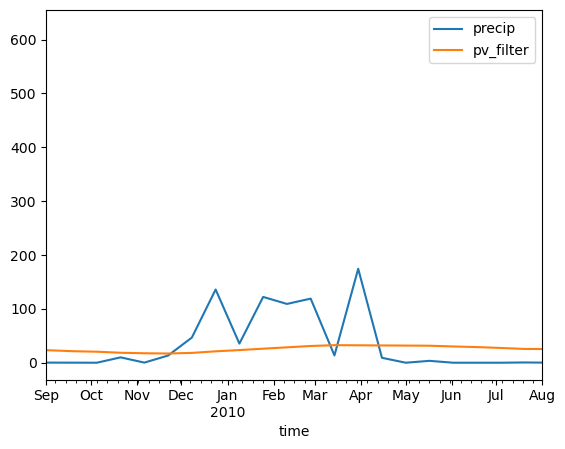

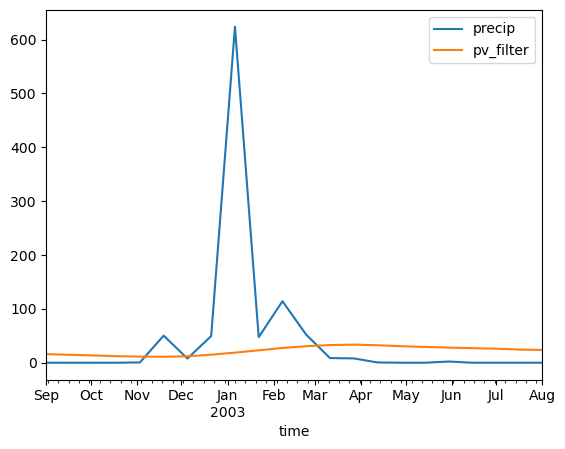

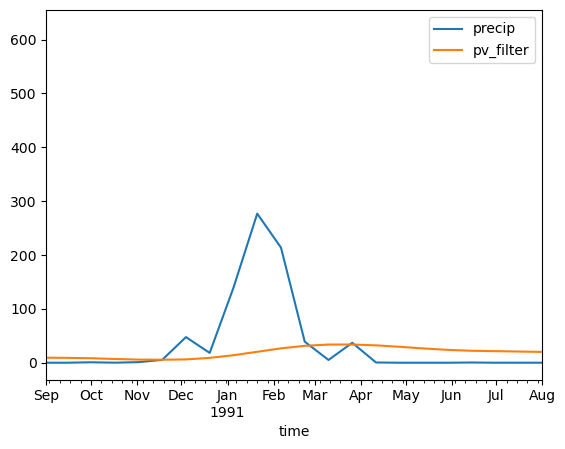

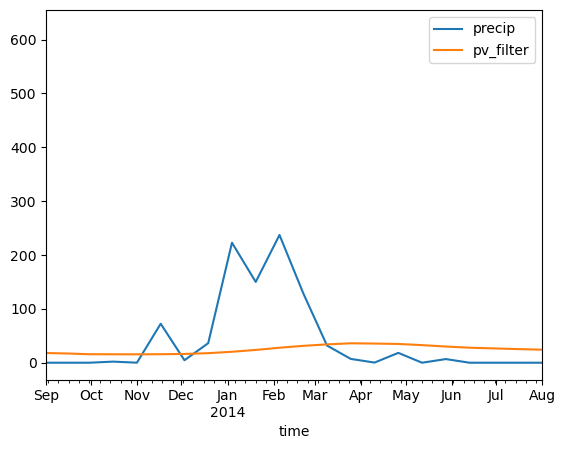

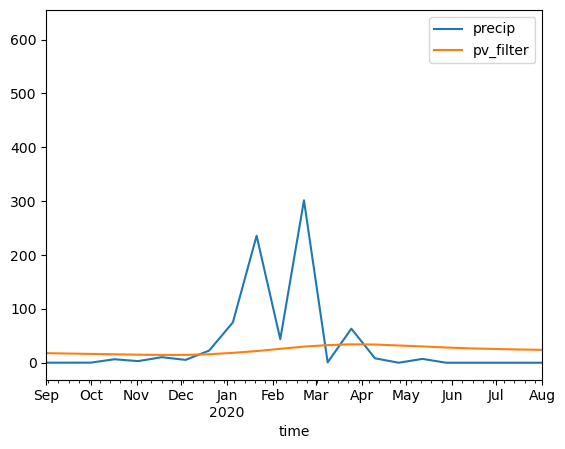

In [39]:
# Some plots 
test.plot(y = ['precip','pv_filter'], xlim  = (pd.Timestamp('2009-09-01'), pd.Timestamp('2010-08-01')))
test.plot(y = ['precip','pv_filter'], xlim  = (pd.Timestamp('2002-09-01'), pd.Timestamp('2003-08-01')))
test.plot(y = ['precip','pv_filter'], xlim  = (pd.Timestamp('1990-09-01'), pd.Timestamp('1991-08-01')))
test.plot(y = ['precip','pv_filter'], xlim  = (pd.Timestamp('2013-09-01'), pd.Timestamp('2014-08-01')))
test.plot(y = ['precip','pv_filter'], xlim  = (pd.Timestamp('2019-09-01'), pd.Timestamp('2020-08-01')))

True
No Fire Dates for NSABHC0023 avaliable
            Unnamed: 0         x          y         bs         pv        npv  \
time                                                                           
1987-09-12         1.5  608165.0  6531775.0  31.260331  25.855372  41.623967   
1987-09-28         3.5  608165.0  6531775.0  33.190083  21.855372  43.690083   
1987-10-14         5.5  608165.0  6531775.0  44.309917  15.024793  39.297521   
1987-10-30         7.5  608165.0  6531775.0  21.541322  21.685950  55.909091   
1987-11-15         9.0  608165.0  6531775.0  46.553719  13.933884  38.247934   
...                ...       ...        ...        ...        ...        ...   
2023-02-03      1544.0  608165.0  6531775.0  35.553719  13.553719  49.487603   
2023-02-19      1545.5  608165.0  6531775.0  38.090909  16.074380  44.289256   
2023-03-07      1547.5  608165.0  6531775.0  39.657025  15.132231  43.640496   
2023-03-23      1549.0  608165.0  6531775.0  39.776860  15.239669  43.479339

ValueError: Length of values (0) does not match length of index (812)

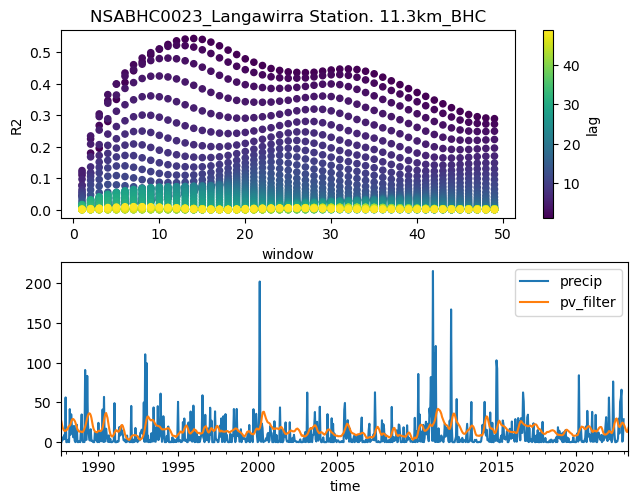

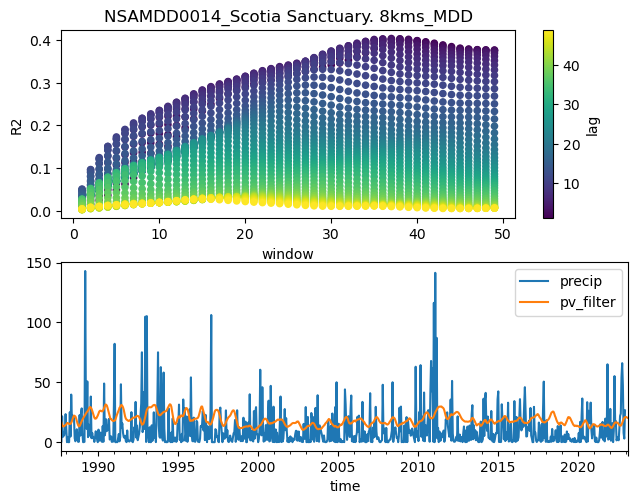

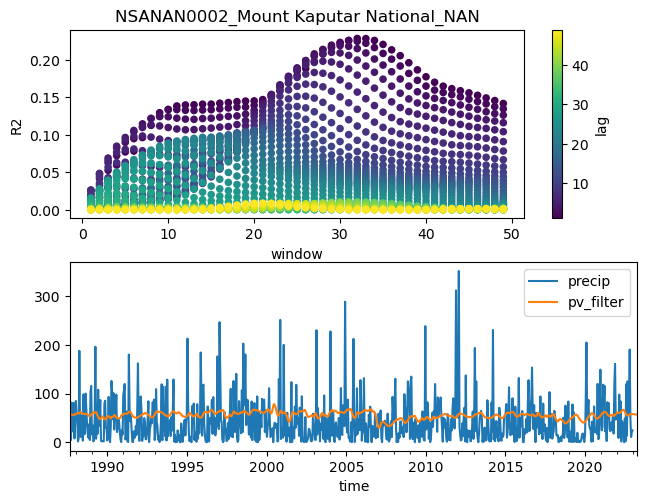

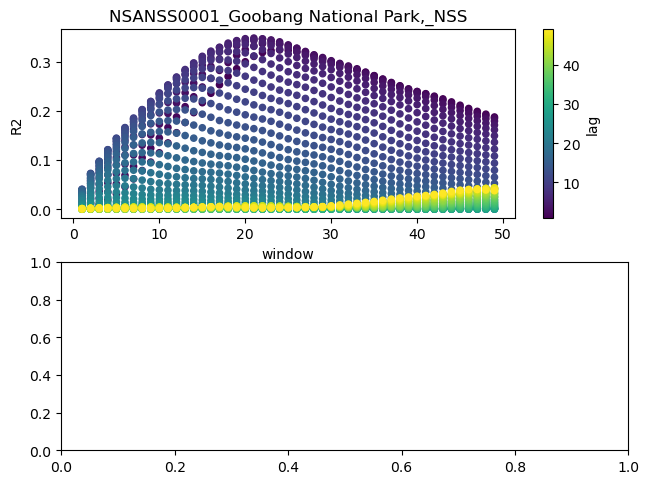

In [24]:
site_scores_grp = site_scores.groupby('site_location_name')

for key in site_scores_grp.groups.keys():
    fig, ax = plt.subplots(2)
    fig.tight_layout()
    site = site_scores_grp.get_group(key)
    first_index = site.index[0] # information will be constant per group so take the first one for simplicity
    site_bioregion_name = site.bioregion_name[first_index] 
    site_description = site.description[first_index].split(' ')
    site_description_str = ' '.join(site_description[:3])
    site.plot.scatter(x = 'window', y = 'R2', c = 'lag', colormap = 'viridis', title = f'{key}_{site_description_str}_{site_bioregion_name}', ax = ax[0])
    site_data = get_site_data(key)
    site_data[['precip', 'pv_filter']].plot(ax = ax[1])
    
    

In [58]:
i = get_site_data(key)

            Unnamed: 0         x          y         bs         pv        npv  \
time                                                                           
1987-09-12         1.5  608165.0  6531775.0  31.260331  25.855372  41.623967   
1987-09-28         3.5  608165.0  6531775.0  33.190083  21.855372  43.690083   
1987-10-14         5.5  608165.0  6531775.0  44.309917  15.024793  39.297521   
1987-10-30         7.5  608165.0  6531775.0  21.541322  21.685950  55.909091   
1987-11-15         9.0  608165.0  6531775.0  46.553719  13.933884  38.247934   
...                ...       ...        ...        ...        ...        ...   
2023-02-03      1544.0  608165.0  6531775.0  35.553719  13.553719  49.487603   
2023-02-19      1545.5  608165.0  6531775.0  38.090909  16.074380  44.289256   
2023-03-07      1547.5  608165.0  6531775.0  39.657025  15.132231  43.640496   
2023-03-23      1549.0  608165.0  6531775.0  39.776860  15.239669  43.479339   
2023-04-08      1550.0  608165.0  653177

In [59]:
i